In [1]:
from sklearn.datasets import fetch_openml
import pandas as pd

# Load dataset from OpenML
adult = fetch_openml(name="adult", version=2, as_frame=True)
df = adult.frame

print(df.head())
print(df.shape)  # (48842, 15)

# Separate features and target
X = df.drop(columns=["class", "education"])
y = df["class"]

   age  workclass  fnlwgt     education  education-num      marital-status  \
0   25    Private  226802          11th              7       Never-married   
1   38    Private   89814       HS-grad              9  Married-civ-spouse   
2   28  Local-gov  336951    Assoc-acdm             12  Married-civ-spouse   
3   44    Private  160323  Some-college             10  Married-civ-spouse   
4   18        NaN  103497  Some-college             10       Never-married   

          occupation relationship   race     sex  capital-gain  capital-loss  \
0  Machine-op-inspct    Own-child  Black    Male             0             0   
1    Farming-fishing      Husband  White    Male             0             0   
2    Protective-serv      Husband  White    Male             0             0   
3  Machine-op-inspct      Husband  Black    Male          7688             0   
4                NaN    Own-child  White  Female             0             0   

   hours-per-week native-country  class  
0       

In [2]:
all_hours = df['hours-per-week'].unique().tolist()
all_hours.sort()

In [3]:
hours_dict = {
    value: i  for i,value in enumerate(all_hours)
}

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.15, stratify=y, random_state=42)

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size= 0.214, stratify=y_train, random_state=42)

In [6]:
X_train['hours-per-week']=X_train['hours-per-week'].map(hours_dict).astype('int32')
X_val['hours-per-week']=X_val['hours-per-week'].map(hours_dict).astype('int32')
X_test['hours-per-week']=X_test['hours-per-week'].map(hours_dict).astype('int32')

In [7]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
ohc = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')
ohc_features = ['native-country', 'race', 'relationship', 'sex', 'occupation', 'marital-status', 'workclass', ]
y_dict = {
    '<=50K': 0,
    '>50K': 1
}
X_train_encoded = ohc.fit_transform(X_train[ohc_features])
X_val_encoded = ohc.transform(X_val[ohc_features])
X_test_encoded = ohc.transform(X_test[ohc_features])


In [8]:
X_train.drop(inplace=True, axis=1, labels=ohc_features)
X_val.drop(inplace=True, axis=1, labels=ohc_features)
X_test.drop(inplace=True, axis=1, labels=ohc_features)

In [9]:
X_train_encoded_df = pd.DataFrame(
    data=X_train_encoded,
    columns=ohc.get_feature_names_out()
)
X_val_encoded_df = pd.DataFrame(
    data=X_val_encoded, # type: ignore
    columns=ohc.get_feature_names_out()
)
X_test_encoded_df = pd.DataFrame(
    data=X_test_encoded, # type: ignore
    columns=ohc.get_feature_names_out()
)

In [10]:
X_train = pd.concat(
    [X_train.reset_index(drop=True),
    X_train_encoded_df.reset_index(drop=True)],
    axis=1
)
X_val = pd.concat(
    [X_val.reset_index(drop=True),
    X_val_encoded_df.reset_index(drop=True)],
    axis=1
)
X_test = pd.concat(
    [X_test.reset_index(drop=True),
    X_test_encoded_df.reset_index(drop=True)],
    axis=1
)

In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
features_to_be_scaled = ['hours-per-week', 'fnlwgt', 'age', 'capital-gain', 'capital-loss', "education-num"]
X_train[features_to_be_scaled] = scaler.fit_transform(X_train[features_to_be_scaled])
X_val[features_to_be_scaled] = scaler.transform(X_val[features_to_be_scaled])
X_test[features_to_be_scaled] = scaler.transform(X_test[features_to_be_scaled])

In [12]:
y_train = y_train.map(y_dict).astype('int32')
y_val = y_val.map(y_dict).astype('int32')
y_test = y_test.map(y_dict).astype('int32')

In [13]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7327 entries, 0 to 7326
Data columns (total 85 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   age                                        7327 non-null   float64
 1   fnlwgt                                     7327 non-null   float64
 2   education-num                              7327 non-null   float64
 3   capital-gain                               7327 non-null   float64
 4   capital-loss                               7327 non-null   float64
 5   hours-per-week                             7327 non-null   float64
 6   native-country_Canada                      7327 non-null   float64
 7   native-country_China                       7327 non-null   float64
 8   native-country_Columbia                    7327 non-null   float64
 9   native-country_Cuba                        7327 non-null   float64
 10  native-country_Dominican

In [14]:
import tensorflow as tf
import keras

2025-10-05 11:32:34.115440: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/local/lib/python3.11/dist-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/usr

In [15]:
class MyModel(keras.Model):
    def __init__(self):
        super().__init__()
        self.layer1 = keras.layers.Dense(128, activation='relu')
        self.layer2 = keras.layers.Dense(128, activation='relu')
        self.final = keras.layers.Dense(1)

    def call(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        return self.final(x)



In [16]:
EPOCHS = 30
BATCH_SIZE = 32

my_model = MyModel()

train_dataset = tf.data.Dataset.from_tensor_slices((X_train.values, y_train.values)).batch(BATCH_SIZE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val.values, y_val.values)).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test.values, y_test.values)).batch(BATCH_SIZE)


my_model.compile(
    optimizer = keras.optimizers.Adam(learning_rate= 0.001), # type: ignore
    loss = keras.losses.BinaryCrossentropy(from_logits=True),
    metrics= [keras.metrics.BinaryAccuracy]
)

I0000 00:00:1759663957.323394  197501 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6143 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [17]:
my_model.fit(
    X_train, 
    y_train, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val)
    )

Epoch 1/30


2025-10-05 11:32:38.911985: I external/local_xla/xla/service/service.cc:163] XLA service 0x7fcb800044d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-05 11:32:38.912034: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Laptop GPU, Compute Capability 8.6
2025-10-05 11:32:38.949286: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-05 11:32:39.163787: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91301
2025-10-05 11:32:39.182505: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-05 11:32:39.

 113/1020 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - binary_accuracy: 0.7939 - loss: 0.4737

I0000 00:00:1759663963.391930  197655 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1007/1020 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8325 - loss: 0.3578

2025-10-05 11:32:44.890942: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-05 11:32:44.890969: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-05 11:32:44.890982: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-05 11:32:45.665756: I external/l

1020/1020 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_accuracy: 0.8326 - loss: 0.3574

2025-10-05 11:32:48.663954: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-05 11:32:48.663983: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-05 11:32:49.780281: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_25', 304 bytes spill stores, 304 bytes spill loads

2025-10-05 11:32:50.143598: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning :

1020/1020 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - binary_accuracy: 0.8448 - loss: 0.3274 - val_binary_accuracy: 0.8470 - val_loss: 0.3113
Epoch 2/30
1020/1020 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary_accuracy: 0.8523 - loss: 0.3088 - val_binary_accuracy: 0.8503 - val_loss: 0.3113
Epoch 3/30
1020/1020 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary_accuracy: 0.8519 - loss: 0.3051 - val_binary_accuracy: 0.8454 - val_loss: 0.3096
Epoch 4/30
1020/1020 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary_accuracy: 0.8538 - loss: 0.3011 - val_binary_accuracy: 0.8514 - val_loss: 0.3135
Epoch 5/30
1020/1020 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary_accuracy: 0.8553 - loss: 0.2984 - val_binary_accuracy: 0.8477 - val_loss: 0.3103
Epoch 6/30
1020/1020 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary_accuracy: 0.8564 - loss: 0.2947 - val_binary_accuracy: 0.8495 - val_loss: 0.3091
Epoch 7/30
1020/1020 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary_accuracy: 0.8572 - loss: 0.2922 - val_binary_accuracy: 0.8506 - val_loss: 0.3118
Ep

In [18]:
my_model_sgd = MyModel()

my_model_sgd.compile(
    optimizer = keras.optimizers.SGD(learning_rate= 0.001), # type: ignore
    loss = keras.losses.BinaryCrossentropy(from_logits=True),
    metrics= [keras.metrics.BinaryAccuracy]
)

my_model_sgd.fit(
    X_train, 
    y_train, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val)
    )

Epoch 1/30


2025-10-05 11:33:41.381406: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-05 11:33:41.381434: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-05 11:33:42.129891: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_289', 12 bytes spill stores, 12 bytes spill loads

2025-10-05 11:33:42.447799: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : 

1020/1020 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - binary_accuracy: 0.7601 - loss: 0.5950 - val_binary_accuracy: 0.7607 - val_loss: 0.5220
Epoch 2/30
1020/1020 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary_accuracy: 0.7606 - loss: 0.4940 - val_binary_accuracy: 0.7608 - val_loss: 0.4717
Epoch 3/30
1020/1020 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary_accuracy: 0.7627 - loss: 0.4516 - val_binary_accuracy: 0.7657 - val_loss: 0.4357
Epoch 4/30
1020/1020 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary_accuracy: 0.7705 - loss: 0.4195 - val_binary_accuracy: 0.7754 - val_loss: 0.4084
Epoch 5/30
1020/1020 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary_accuracy: 0.7823 - loss: 0.3954 - val_binary_accuracy: 0.7908 - val_loss: 0.3884
Epoch 6/30
1020/1020 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary_accuracy: 0.7980 - loss: 0.3779 - val_binary_accuracy: 0.8052 - val_loss: 0.3742
Epoch 7/30
1020/1020 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary_accuracy: 0.8123 - loss: 0.3656 - val_binary_accuracy: 0.8153 - val_loss: 0.3640
Epo

In [19]:
my_model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)

205/229 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8483 - loss: 0.4154

2025-10-05 11:34:37.912433: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-05 11:34:37.912486: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-05 11:34:38.971042: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_25', 304 bytes spill stores, 304 bytes spill loads

2025-10-05 11:34:39.062532: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning :

229/229 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - binary_accuracy: 0.8486 - loss: 0.4386


[0.4386412799358368, 0.8486419916152954]

In [20]:
my_model_sgd.evaluate(X_test, y_test, batch_size=BATCH_SIZE)

229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - binary_accuracy: 0.8531 - loss: 0.3123


[0.3122904598712921, 0.8531458973884583]

Adam slightly outperforms SGD here and generally is better for complex models for its use of adaptive learning rate as well as momentum 

In [21]:
import time 


train_times = []
accuracies = []
histories = []

for batch in [64, 128, 256, 512, 1024]:

    BATCH_SIZE = batch

    temp_model = MyModel()

    train_dataset = tf.data.Dataset.from_tensor_slices((X_train.values, y_train.values)).batch(BATCH_SIZE)
    val_dataset = tf.data.Dataset.from_tensor_slices((X_val.values, y_val.values)).batch(BATCH_SIZE)
    test_dataset = tf.data.Dataset.from_tensor_slices((X_test.values, y_test.values)).batch(BATCH_SIZE)


    temp_model.compile(
        optimizer = keras.optimizers.Adam(learning_rate= 0.001), # type: ignore
        loss = keras.losses.BinaryCrossentropy(from_logits=True),
        metrics= [keras.metrics.BinaryAccuracy]
    )
    start_time = time.time()
    history = temp_model.fit(
    X_train, 
    y_train, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val)
    )
    end_time = time.time()
    
    accuracies.append(temp_model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)[1])
    train_times.append(end_time - start_time)
    histories.append(history.history)
    

Epoch 1/30


2025-10-05 11:34:41.593853: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-05 11:34:41.593883: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-05 11:34:41.593898: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-05 11:34:41.593912: I external/l

493/510 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8281 - loss: 0.3596

2025-10-05 11:34:46.261342: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-05 11:34:46.261373: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-05 11:34:46.261387: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-05 11:34:46.261402: I external/l

510/510 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - binary_accuracy: 0.8286 - loss: 0.3586

2025-10-05 11:34:50.909813: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-05 11:34:50.909843: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-05 11:34:51.506632: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_25', 4 bytes spill stores, 4 bytes spill loads

2025-10-05 11:34:51.805361: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Reg

510/510 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - binary_accuracy: 0.8429 - loss: 0.3280 - val_binary_accuracy: 0.8470 - val_loss: 0.3124
Epoch 2/30
510/510 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.8514 - loss: 0.3103 - val_binary_accuracy: 0.8464 - val_loss: 0.3109
Epoch 3/30
510/510 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.8532 - loss: 0.3057 - val_binary_accuracy: 0.8445 - val_loss: 0.3093
Epoch 4/30
510/510 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.8534 - loss: 0.3024 - val_binary_accuracy: 0.8478 - val_loss: 0.3096
Epoch 5/30
510/510 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.8550 - loss: 0.3000 - val_binary_accuracy: 0.8487 - val_loss: 0.3088
Epoch 6/30
510/510 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.8553 - loss: 0.2968 - val_binary_accuracy: 0.8470 - val_loss: 0.3120
Epoch 7/30
510/510 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.8571 - loss: 0.2936 - val_binary_accuracy: 0.8530 - val_loss: 0.3117
Epoch 8/30
510/

2025-10-05 11:35:20.950936: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-05 11:35:20.950968: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-05 11:35:20.950985: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-05 11:35:20.951001: I external/l

233/255 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8131 - loss: 0.3950

2025-10-05 11:35:25.400242: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-05 11:35:25.400274: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-05 11:35:25.400291: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-05 11:35:25.400308: I external/l

255/255 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - binary_accuracy: 0.8382 - loss: 0.3381 - val_binary_accuracy: 0.8485 - val_loss: 0.3115
Epoch 2/30
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.8511 - loss: 0.3087 - val_binary_accuracy: 0.8517 - val_loss: 0.3140
Epoch 3/30
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.8538 - loss: 0.3062 - val_binary_accuracy: 0.8389 - val_loss: 0.3127
Epoch 4/30
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.8544 - loss: 0.3026 - val_binary_accuracy: 0.8509 - val_loss: 0.3119
Epoch 5/30
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.8545 - loss: 0.2999 - val_binary_accuracy: 0.8506 - val_loss: 0.3087
Epoch 6/30
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.8560 - loss: 0.2982 - val_binary_accuracy: 0.8469 - val_loss: 0.3086
Epoch 7/30
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.8570 - loss: 0.2949 - val_binary_accuracy: 0.8445 - val_loss: 0.3112
Epoch 8/30
255/

2025-10-05 11:35:46.843588: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-05 11:35:46.843646: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-05 11:35:46.843667: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-05 11:35:47.184047: I external/l

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - binary_accuracy: 0.8010 - loss: 0.4343

2025-10-05 11:35:51.636697: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-05 11:35:51.636735: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-05 11:35:52.307524: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_18', 4 bytes spill stores, 4 bytes spill loads

2025-10-05 11:35:52.658322: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Reg

128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - binary_accuracy: 0.8274 - loss: 0.3613 - val_binary_accuracy: 0.8420 - val_loss: 0.3144
Epoch 2/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.8510 - loss: 0.3103 - val_binary_accuracy: 0.8441 - val_loss: 0.3135
Epoch 3/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.8530 - loss: 0.3068 - val_binary_accuracy: 0.8473 - val_loss: 0.3099
Epoch 4/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.8545 - loss: 0.3033 - val_binary_accuracy: 0.8493 - val_loss: 0.3099
Epoch 5/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.8564 - loss: 0.3012 - val_binary_accuracy: 0.8512 - val_loss: 0.3091
Epoch 6/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.8572 - loss: 0.2995 - val_binary_accuracy: 0.8493 - val_loss: 0.3091
Epoch 7/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.8576 - loss: 0.2971 - val_binary_accuracy: 0.8473 - val_loss: 0.3094
Epoch 8/30
128/1

2025-10-05 11:36:02.624357: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-05 11:36:02.624395: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-05 11:36:03.329807: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_18', 4 bytes spill stores, 4 bytes spill loads

2025-10-05 11:36:03.689788: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Reg

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - binary_accuracy: 0.8510 - loss: 0.3314
Epoch 1/30


2025-10-05 11:36:05.421524: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-05 11:36:05.421565: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-05 11:36:05.421591: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-05 11:36:06.479729: I external/l

38/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7753 - loss: 0.5004 

2025-10-05 11:36:08.535596: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-05 11:36:08.535649: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-05 11:36:08.535684: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-05 11:36:08.983094: I external/l

64/64 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - binary_accuracy: 0.8131 - loss: 0.3867 - val_binary_accuracy: 0.8433 - val_loss: 0.3244
Epoch 2/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.8502 - loss: 0.3148 - val_binary_accuracy: 0.8481 - val_loss: 0.3126
Epoch 3/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.8532 - loss: 0.3082 - val_binary_accuracy: 0.8500 - val_loss: 0.3108
Epoch 4/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.8551 - loss: 0.3049 - val_binary_accuracy: 0.8503 - val_loss: 0.3099
Epoch 5/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.8556 - loss: 0.3025 - val_binary_accuracy: 0.8506 - val_loss: 0.3113
Epoch 6/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.8550 - loss: 0.3013 - val_binary_accuracy: 0.8472 - val_loss: 0.3088
Epoch 7/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.8567 - loss: 0.2999 - val_binary_accuracy: 0.8456 - val_loss: 0.3103
Epoch 8/30
64/64 ━━━━━━━━━━━━━

2025-10-05 11:36:20.175027: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-05 11:36:20.992190: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_118', 104 bytes spill stores, 104 bytes spill loads



 1/32 ━━━━━━━━━━━━━━━━━━━━ 1:27 3s/step - binary_accuracy: 0.7451 - loss: 0.6967

2025-10-05 11:36:22.285165: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-05 11:36:22.908957: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_118', 4 bytes spill stores, 4 bytes spill loads

2025-10-05 11:36:23.251282: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_118', 156 bytes spill stores, 156 bytes spill loads



32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - binary_accuracy: 0.7628 - loss: 0.5522

2025-10-05 11:36:24.624951: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-05 11:36:25.161860: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_18', 4 bytes spill stores, 4 bytes spill loads

2025-10-05 11:36:25.374796: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_18', 156 bytes spill stores, 156 bytes spill loads



32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - binary_accuracy: 0.7814 - loss: 0.4606 - val_binary_accuracy: 0.8301 - val_loss: 0.3409
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_accuracy: 0.8465 - loss: 0.3257 - val_binary_accuracy: 0.8422 - val_loss: 0.3192
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_accuracy: 0.8498 - loss: 0.3143 - val_binary_accuracy: 0.8468 - val_loss: 0.3132
Epoch 4/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_accuracy: 0.8523 - loss: 0.3102 - val_binary_accuracy: 0.8483 - val_loss: 0.3119
Epoch 5/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_accuracy: 0.8541 - loss: 0.3067 - val_binary_accuracy: 0.8492 - val_loss: 0.3105
Epoch 6/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_accuracy: 0.8546 - loss: 0.3048 - val_binary_accuracy: 0.8502 - val_loss: 0.3097
Epoch 7/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_accuracy: 0.8552 - loss: 0.3025 - val_binary_accuracy: 0.8506 - val_loss: 0.3097
Epoch 8/30
32/32 ━━━━━━━━━━━━

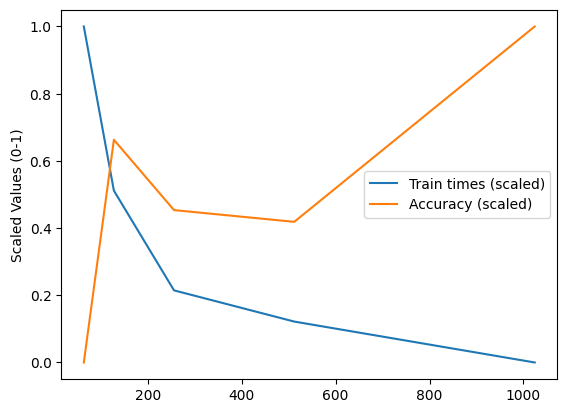

In [22]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np

tested_epochs = [64, 128, 256, 512, 1024]
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

scaler = MinMaxScaler()

# Reshape and scale
train_times_scaled = scaler.fit_transform(np.array(train_times).reshape(-1, 1)).flatten()
accuracies_scaled = scaler.fit_transform(np.array(accuracies).reshape(-1, 1)).flatten()

plt.plot(tested_epochs, train_times_scaled, label="Train times (scaled)", color=colors[0])
plt.plot(tested_epochs, accuracies_scaled, label="Accuracy (scaled)", color=colors[1])

plt.legend()
plt.ylabel("Scaled Values (0-1)")
plt.show()

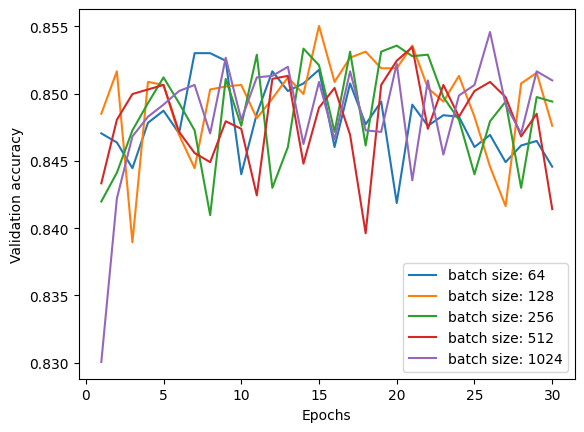

In [23]:

for index, ledger in enumerate(histories):
    epoch_index = [i+1 for i in range(len(ledger["binary_accuracy"]))]
    validation_accuracy = ledger["val_binary_accuracy"]
    plt.plot(epoch_index, validation_accuracy, label = f"batch size: {tested_epochs[index]}")

plt.legend()
plt.ylabel("Validation accuracy")
plt.xlabel("Epochs")
plt.show()

In [24]:
class LargeModel(keras.Model):
    def __init__(self):
        super().__init__()
        self.layer1 = keras.layers.Dense(1024, 
                                         activation='relu',
                                         kernel_initializer="he_normal"
                                         )
        self.layer2 = keras.layers.Dense(1024, 
                                         activation='relu',
                                         kernel_initializer="he_normal"
                                         )
        self.final = keras.layers.Dense(1)

    def call(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        return self.final(x)
    
large_model = LargeModel()


In [25]:
large_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01), #type: ignore
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[
        'binary_accuracy'
    ]
)

history = large_model.fit(
    X_train,
    y_train,
    batch_size=32,
    validation_data=(X_val, y_val),
    epochs=50
)

Epoch 1/50


2025-10-05 11:36:31.822491: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-05 11:36:31.822527: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-05 11:36:32.826468: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_385', 12 bytes spill stores, 12 bytes spill loads

2025-10-05 11:36:33.632589: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : 

1015/1020 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8212 - loss: 0.4563

2025-10-05 11:36:36.296366: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_373', 4 bytes spill stores, 4 bytes spill loads



1020/1020 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - binary_accuracy: 0.8344 - loss: 0.3497 - val_binary_accuracy: 0.8334 - val_loss: 0.3178
Epoch 2/50
1020/1020 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary_accuracy: 0.8446 - loss: 0.3192 - val_binary_accuracy: 0.8457 - val_loss: 0.3278
Epoch 3/50
1020/1020 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary_accuracy: 0.8447 - loss: 0.3237 - val_binary_accuracy: 0.8258 - val_loss: 0.3210
Epoch 4/50
1020/1020 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary_accuracy: 0.8470 - loss: 0.3147 - val_binary_accuracy: 0.8407 - val_loss: 0.3361
Epoch 5/50
1020/1020 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary_accuracy: 0.8499 - loss: 0.3077 - val_binary_accuracy: 0.8479 - val_loss: 0.3250
Epoch 6/50
1020/1020 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary_accuracy: 0.8527 - loss: 0.3014 - val_binary_accuracy: 0.8477 - val_loss: 0.3147
Epoch 7/50
1020/1020 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary_accuracy: 0.8518 - loss: 0.3005 - val_binary_accuracy: 0.8505 - val_loss: 0.3216
Epo

When 

In [26]:
with tf.GradientTape() as tape:
    predictions = large_model(tf.convert_to_tensor(X_train.values), training=True)
    loss = keras.losses.binary_crossentropy(tf.convert_to_tensor(y_train.values.reshape([-1, 1])), predictions)
grads = tape.gradient(loss, large_model.trainable_variables)

for g, var in zip(grads, large_model.trainable_variables): #type: ignore
    if g is None:
        print(f"No gradient for {var.name}!")
    else:
        print(f"Gradient norm for {var.name}: {tf.norm(g).numpy()}")

Gradient norm for kernel: 4383.6865234375
Gradient norm for bias: 1646.6617431640625
Gradient norm for kernel: 17101.65625
Gradient norm for bias: 1338.3856201171875
Gradient norm for kernel: 12129.1416015625
Gradient norm for bias: 10082.232421875


In [27]:
print(history.history.keys())

dict_keys(['binary_accuracy', 'loss', 'val_binary_accuracy', 'val_loss'])


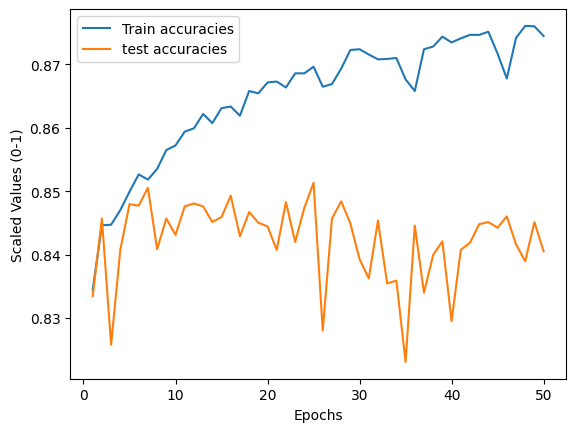

In [28]:

train_accuracies = history.history["binary_accuracy"]
test_accuracies = history.history["val_binary_accuracy"]
epoch_index = [i+1 for i in range(len(train_accuracies))]
plt.plot(epoch_index, train_accuracies, label="Train accuracies", color=colors[0])
plt.plot(epoch_index, test_accuracies, label="test accuracies", color=colors[1])

plt.legend()
plt.ylabel("Scaled Values (0-1)")
plt.xlabel("Epochs")
plt.show()

In [33]:

class LargeModelRegularized(keras.Model):
    def __init__(self):
        super().__init__()
        self.layer1 = keras.layers.Dense(
            1024, 
            activation='relu',
            kernel_initializer="he_normal",
            kernel_regularizer= keras.regularizers.l2(l2=0.001)
            )
        self.layer2 = keras.layers.Dense(
            1024, 
            activation='relu',
            kernel_initializer="he_normal",
            kernel_regularizer= keras.regularizers.l2(l2=0.001)                                       
            )
        self.final = keras.layers.Dense(1)

    def call(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        return self.final(x)
    
large_model_regularized = LargeModelRegularized()

In [34]:
large_model_regularized.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01), #type: ignore
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[
        'binary_accuracy'
    ]
)

history = large_model_regularized.fit(
    X_train,
    y_train,
    batch_size=32,
    validation_data=(X_val, y_val),
    epochs=50
)

Epoch 1/50
1020/1020 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - binary_accuracy: 0.8367 - loss: 0.5100 - val_binary_accuracy: 0.8445 - val_loss: 0.3420
Epoch 2/50
1020/1020 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary_accuracy: 0.8452 - loss: 0.3386 - val_binary_accuracy: 0.8377 - val_loss: 0.3344
Epoch 3/50
1020/1020 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary_accuracy: 0.8473 - loss: 0.3327 - val_binary_accuracy: 0.8375 - val_loss: 0.3290
Epoch 4/50
1020/1020 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary_accuracy: 0.8471 - loss: 0.3301 - val_binary_accuracy: 0.8455 - val_loss: 0.3260
Epoch 5/50
1020/1020 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary_accuracy: 0.8459 - loss: 0.3298 - val_binary_accuracy: 0.8479 - val_loss: 0.3315
Epoch 6/50
1020/1020 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary_accuracy: 0.8481 - loss: 0.3292 - val_binary_accuracy: 0.8357 - val_loss: 0.3356
Epoch 7/50
1020/1020 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary_accuracy: 0.8477 - loss: 0.3288 - val_binary_accuracy: 0.8351 - val_loss:

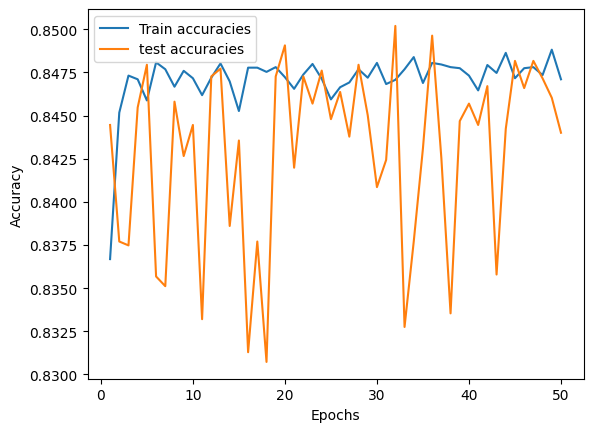

In [35]:

train_accuracies = history.history["binary_accuracy"]
test_accuracies = history.history["val_binary_accuracy"]
epoch_index = [i+1 for i in range(len(train_accuracies))]
plt.plot(epoch_index, train_accuracies, label="Train accuracies", color=colors[0])
plt.plot(epoch_index, test_accuracies, label="test accuracies", color=colors[1])

plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.show()

In [40]:
class LargeModelDropout(keras.Model):
    def __init__(self):
        super().__init__()
        self.layer1 = keras.layers.Dense(
            1024, 
            activation='relu',
            kernel_initializer="he_normal",
            )
        self.drop1 = keras.layers.Dropout(0.3)
        self.layer2 = keras.layers.Dense(
            1024, 
            activation='relu',
            kernel_initializer="he_normal",                                    
            )
        self.drop2 = keras.layers.Dropout(0.3)
        self.final = keras.layers.Dense(1)

    def call(self, x):
        x = self.layer1(x)
        x = self.drop1(x)
        x = self.layer2(x)
        x = self.drop2(x)
        return self.final(x)
    
large_model_dropout = LargeModelDropout()

In [ ]:
large_model_dropout.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01), #type: ignore
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[
        'binary_accuracy'
    ]
)

history = large_model_dropout.fit(
    X_train,
    y_train,
    batch_size=32,
    validation_data=(X_val, y_val),
    epochs=50,
)

Epoch 1/50
1020/1020 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - binary_accuracy: 0.8381 - loss: 0.3533 - val_binary_accuracy: 0.8293 - val_loss: 0.3202
Epoch 2/50
1020/1020 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary_accuracy: 0.8455 - loss: 0.3167 - val_binary_accuracy: 0.8418 - val_loss: 0.3211
Epoch 3/50
1020/1020 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary_accuracy: 0.8469 - loss: 0.3197 - val_binary_accuracy: 0.8125 - val_loss: 0.3365
Epoch 4/50
1020/1020 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary_accuracy: 0.8481 - loss: 0.3100 - val_binary_accuracy: 0.8505 - val_loss: 0.3130
Epoch 5/50
1020/1020 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary_accuracy: 0.8493 - loss: 0.3145 - val_binary_accuracy: 0.8530 - val_loss: 0.3263
Epoch 6/50
1020/1020 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary_accuracy: 0.8529 - loss: 0.3027 - val_binary_accuracy: 0.8433 - val_loss: 0.3190
Epoch 7/50
1020/1020 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary_accuracy: 0.8567 - loss: 0.2970 - val_binary_accuracy: 0.8513 - val_loss:

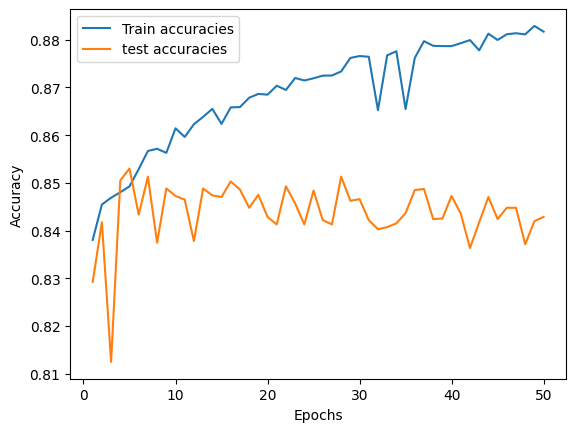

In [42]:

train_accuracies = history.history["binary_accuracy"]
test_accuracies = history.history["val_binary_accuracy"]
epoch_index = [i+1 for i in range(len(train_accuracies))]
plt.plot(epoch_index, train_accuracies, label="Train accuracies", color=colors[0])
plt.plot(epoch_index, test_accuracies, label="test accuracies", color=colors[1])

plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.show()

In [43]:
my_model = MyModel()

my_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01), #type: ignore
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

history_full = my_model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=100,
    validation_data=(X_val, y_val) 
)

Epoch 1/100
1020/1020 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - binary_accuracy: 0.8416 - loss: 0.3277 - val_binary_accuracy: 0.8406 - val_loss: 0.3223
Epoch 2/100
1020/1020 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary_accuracy: 0.8481 - loss: 0.3147 - val_binary_accuracy: 0.8418 - val_loss: 0.3173
Epoch 3/100
1020/1020 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary_accuracy: 0.8518 - loss: 0.3099 - val_binary_accuracy: 0.8429 - val_loss: 0.3174
Epoch 4/100
1020/1020 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary_accuracy: 0.8498 - loss: 0.3086 - val_binary_accuracy: 0.8497 - val_loss: 0.3186
Epoch 5/100
1020/1020 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary_accuracy: 0.8522 - loss: 0.3025 - val_binary_accuracy: 0.8464 - val_loss: 0.3107
Epoch 6/100
1020/1020 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary_accuracy: 0.8532 - loss: 0.2999 - val_binary_accuracy: 0.8456 - val_loss: 0.3134
Epoch 7/100
1020/1020 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary_accuracy: 0.8541 - loss: 0.2973 - val_binary_accuracy: 0.8532 - va

In [44]:
my_model_early = MyModel()

my_model_early.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01), #type: ignore
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

history_early = my_model_early.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks = [
        keras.callbacks.EarlyStopping(patience = 3)
    ]
)

Epoch 1/100
1020/1020 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - binary_accuracy: 0.8426 - loss: 0.3264 - val_binary_accuracy: 0.8131 - val_loss: 0.3275
Epoch 2/100
1020/1020 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary_accuracy: 0.8462 - loss: 0.3141 - val_binary_accuracy: 0.8411 - val_loss: 0.3174
Epoch 3/100
1020/1020 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary_accuracy: 0.8485 - loss: 0.3105 - val_binary_accuracy: 0.8475 - val_loss: 0.3152
Epoch 4/100
1020/1020 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary_accuracy: 0.8506 - loss: 0.3056 - val_binary_accuracy: 0.8438 - val_loss: 0.3196
Epoch 5/100
1020/1020 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary_accuracy: 0.8519 - loss: 0.3027 - val_binary_accuracy: 0.8531 - val_loss: 0.3110
Epoch 6/100
1020/1020 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary_accuracy: 0.8526 - loss: 0.3000 - val_binary_accuracy: 0.8431 - val_loss: 0.3136
Epoch 7/100
1020/1020 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary_accuracy: 0.8532 - loss: 0.2961 - val_binary_accuracy: 0.8494 - va

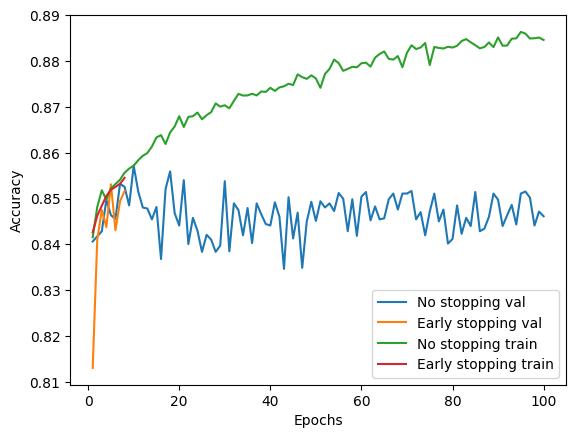

In [46]:
full_accuracies = history_full.history["val_binary_accuracy"]
early_accuracies = history_early.history["val_binary_accuracy"]
full_train_accuracies = history_full.history["binary_accuracy"]
early_train_accuracies = history_early.history["binary_accuracy"]
epoch_index_full = [i+1 for i in range(len(full_accuracies))]
epoch_index_early = [i+1 for i in range(len(early_accuracies))]
plt.plot(epoch_index_full, full_accuracies, label="No stopping val", color=colors[0])
plt.plot(epoch_index_early, early_accuracies, label="Early stopping val", color=colors[1])
plt.plot(epoch_index_full, full_train_accuracies, label="No stopping train", color=colors[2])
plt.plot(epoch_index_early, early_train_accuracies, label="Early stopping train", color=colors[3])

plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.show()